In [ ]:
# Try transfer learning for Fudenberg (HEAD part only?)

In [ ]:
# is batchNormalization used properly?

In [3]:
pip install natsort

  Using cached https://files.pythonhosted.org/packages/0f/65/81883897f4aaa1e53deaa65137318cfe80b36ce013c2e86f8fd0843cfa02/natsort-7.0.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Try their model straightaway
import os
import json
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
import tensorflow as tf
print(tf.__version__)
if tf.__version__[0] == '1':
    tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cooltools.lib.numutils import set_diag
from basenji import dataset, dna_io, seqnn

1.14.0


In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 500)

import h5py
import random

import math
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.framework import ops
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import cooler
import cooltools as ct

from Bio import SeqIO

import pickle

import scipy
import os
import re

In [7]:
def plot_hic(matrix, use_log_scale = False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    if use_log_scale:
        im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
        fig.colorbar(im)
    else:
        im = ax.matshow(matrix, cmap='YlOrRd')
        fig.colorbar(im)
    

In [8]:
def one_hot_dna(sequences = {}):
    for k,v in sequences.items():
        seq_array = np.array(list(v))

        label_encoder = LabelEncoder()
        integer_encoded_seq = label_encoder.fit_transform(seq_array)

        integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)

        onehot_encoder = OneHotEncoder(sparse = False)
        result = onehot_encoder.fit_transform(integer_encoded_seq)
        
        # if Ns are present in the DNA sequence, result will have 5 columns. We delete 4th column which has Ns
        # N row in the resulting training set will have all 0s
        if result.shape[1] == 5:
            result = np.delete(result, 3, 1)
        
        sequences[k] = result

In [49]:
# Colab specific code
# filepath = "drive/My Drive/Colab Notebooks/S2-Wang2017-async.dm3.mapq_30.100.mcool"

filepath = "S2-Wang2017-async.dm3.mapq_30.100.mcool"

resolution = "::/resolutions/2000" # 1 KB resolution
c = cooler.Cooler(filepath + resolution)

chroms = c.chromnames
# don't use these small chromosomes
chroms.remove("chrM")
chroms.remove("chr4")

In [54]:
arr = c.matrix(balance=True).fetch('chr2R')

In [55]:
arr_raw = c.matrix(balance=False).fetch('chr2R')

In [10]:
sequences = {}
for chrom in chroms:
    fasta_sequence = list(SeqIO.parse(open(f"./chromFa/{chrom}.fa"),'fasta'))[0]
    sequences[chrom] = str(fasta_sequence.seq)

In [11]:
chr2R = sequences['chr2R']

In [106]:
model_dir = "./basenji/"
params_file = model_dir+'params.json'
model_file  = model_dir+'model_best.h5'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seq_length = params_model['seq_length']
target_length = params_model['target_length']
target_crop = params_model['target_crop']
seqnn_model = seqnn.SeqNN(params_model)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1048576, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement_1 ((None, 1048576, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift_1 (StochasticS (None, 1048576, 4)   0           stochastic_reverse_complement_1[0
__________________________________________________________________________________________________
re_lu_42 (ReLU)                 (None, 1048576, 4)   0           stochastic_shift_1[0][0]         
____________________________________________________________________________________________

In [108]:
seqnn_model.restore(model_file)
print('successfully loaded')

successfully loaded


In [151]:
target_crop = params_model['target_crop']
hic_diags = 2
target_length_cropped = target_length - 2*target_crop
tlen = (target_length_cropped - hic_diags) * (target_length_cropped - hic_diags+1) // 2

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

tlen, target_length_cropped

(99681, 448)

In [180]:
FACTOR = 15

In [181]:
seq = chr2R[seq_length*FACTOR:seq_length*(FACTOR+1)]
if len(seq) != seq_length: raise ValueError('len(seq) != seq_length')

seq_1hot = dna_io.dna_1hot(seq, n_random=False)

test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0))

In [164]:
seq[0:100]

'GTGAAAATTGGAAAGTTGCCGCCTTCGAGAACTTTGAACCGCCGCCGATCTGCTCCGGATCTGTTCCACTGATCCAAAAATCGCCTTTGATGAACGCCGA'

In [161]:
seq_1hot[0:100, :] # ACGT Порядок

array([[False, False,  True, False],
       [False, False, False,  True],
       [False, False,  True, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False,  True, False],
       [False, False,  True, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [False, False,  True, False],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False, False, False,  True],
       [False, False, False,  True],
       [False,  True, False, False],
       [False, False,  True, False],
 

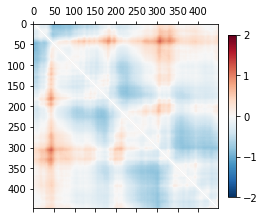

In [182]:
plt.figure(figsize=(8,4))
target_index = 0
vmin=-2; vmax=2

# plot pred
plt.subplot(121) 
mat = from_upper_triu(test_pred_from_seq[:,:,target_index]  , target_length -2* target_crop , 2)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);

In [183]:
transformed_arr = transform_hic(arr[int(seq_length*FACTOR/2000):int(seq_length*(FACTOR+1)/2000), int(seq_length*FACTOR/2000):int(seq_length*(FACTOR+1)/2000)],
                               arr_raw[int(seq_length*FACTOR/2000):int(seq_length*(FACTOR+1)/2000), int(seq_length*FACTOR/2000):int(seq_length*(FACTOR+1)/2000)])

CROPPING_TARGET = 32
cropped_transformed_arr = transformed_arr[CROPPING_TARGET:transformed_arr.shape[0] - CROPPING_TARGET, 
                                             CROPPING_TARGET:transformed_arr.shape[1] - CROPPING_TARGET]

/Users/neil/anaconda3/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/Users/neil/anaconda3/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: divide by zero encountered in true_divide
  val_cur = ar_cur / armask_cur


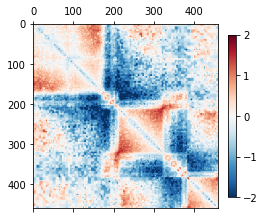

In [184]:
plt.figure(figsize=(8,4))
target_index = 0
vmin=-2; vmax=2

# plot pred
plt.subplot(121) 

im = plt.matshow(cropped_transformed_arr, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);

In [186]:
print(int(seq_length*FACTOR/2000))
print(int(seq_length*(FACTOR+1)/2000))

print(seq_length*FACTOR)
print(seq_length*(FACTOR+1))

7864
8388
15728640
16777216


In [188]:
16777216/ 2000

8388.608

In [45]:
# combine all the transformations in one function
def transform_hic(hic_matrix, hic_matrix_raw):
    transformed_arr = ct.lib.numutils.adaptive_coarsegrain(hic_matrix, hic_matrix_raw)
    transformed_arr, _, _, _ = ct.lib.numutils.observed_over_expected(transformed_arr, mask = ~np.isnan(transformed_arr))
    transformed_arr = np.log(transformed_arr)
    transformed_arr = ct.lib.numutils.interp_nan(transformed_arr)
    transformed_arr = scipy.ndimage.gaussian_filter(transformed_arr, sigma = 1)
    
    return transformed_arr

In [ ]:
# Just Fudenberg model doesn't work well on Dropsophila Melanogaster => Try transfer learning

In [94]:
512 * 2048

1048576

In [96]:
512000 / 1000

512.0

In [ ]:
# Входных нейронов должно быть 512.000, чтобы 512x512 в HEAD имело такой же смысл, как у Fudenberg'а
# Еще надо убрать последний кропающий слой

In [101]:
512000 / 2**10

500.0

In [ ]:
#Надо уменьшать, но не так сильно

In [105]:
2**10 * 512
# наверное самое простое использовать такой входной массив

524288

In [ ]:
# try both fine-tuning (not freezing any layers) and transfer learning (freezing some of the layers)
# https://datascience.stackexchange.com/questions/41231/does-fine-tuning-of-transferred-layers-perform-better-than-frozen-transferred-la